In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand, randn
from scipy.linalg import inv, svd
from scipy.optimize import linprog
from tqdm import tqdm_notebook as tqdm

def null_space(A, rcond=None):
    u, s, vh = svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q

### Exercise 1

Let $U$ and $W$ be subspaces of $\mathbb{R}^5$ that are spanned, respectively, by the columns of the matrices $A$ and $B$ (shown below). 
Write a function `altproj(A,B,v0,n)` that returns $\underline{v}_{2n}$ after $2n$ steps of alternating projection onto $U$ and $W$ starting from $\underline{v}_0$. 
Use this function to find the orthogonal projection of $\underline{v}_0$ (shown below) onto $ U \cap W $. How large should $n$ be chosen so that the projection is correct to 4 decimal places (e.g., absolute error at most 0.0001 in each coordinate)?
$$
A = 
\begin{bmatrix}
 3 & 2 & 3 \\ 1 & 5 & 7 \\ 4 & 11 & 13 \\ 1 & 17 & 19 \\ 5 & 23 & 29
\end{bmatrix}, \qquad
B = 
\begin{bmatrix}
 1 & 1 & 2.5 \\ 2 & 0 & 6 \\ 2 & 1 & 12 \\ 2 & 0 & 18 \\ 6 & -3 & 26
\end{bmatrix}, \qquad
\underline{v}_0 =
\begin{bmatrix}
 1 \\2 \\ 3 \\ 4 \\ 5
\end{bmatrix}
$$
To find the intersection of $U$ and $W$, we note that the following Python snippet returns a matrix whose columns span $ U \cap W $
```
basis_UintW = np.hstack([A, B]) @ null_space(np.hstack([A, -B])) 
```

In [4]:
def altproj(A, B, v0, n):
    """
    Arguments:
        A {numpy.ndarray} -- matrix whose column span is vector space U
        B {numpy.ndarray} -- matrix whose column span is vector space W
        v0 {numpy.ndarray} -- initialization vector
        n {int} -- number of sweeps for alternating projection
    Returns:
        v {numpy.ndarray} -- the output after 2n steps of alternating projection
        err {numpy.ndarray} -- the error after each full pass
    """
    # Construct projection matrix
    PU = np.matmul(A, np.linalg.pinv(A))
    PW = np.matmul(B, np.linalg.pinv(B))
    # Compute the exact solution
    basis_UintW = np.hstack([A, B]) @ null_space(np.hstack([A, -B])) 
    P_UintW = np.matmul(basis_UintW, np.linalg.pinv(basis_UintW))
    v_star = np.matmul(P_UintW, v0)
    # Apply n sweeps of alternating projection
    v, err = v0, np.zeros(n)
    for t in tqdm(range(2 * n), total=2 * n, leave=False):
        v = np.matmul(PU, v) if (t + 1) % 2 == 0 else np.matmul(PW, v)
        if (t + 1) % 2 == 0:
            err[t // 2] = np.linalg.norm(v-v_star)
    return v, err

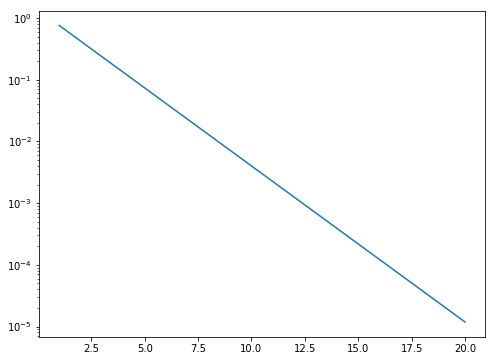

In [5]:
A = np.array([[3, 1, 4, 1, 5], [2, 5, 11, 17, 23], [3, 7, 13, 19, 29]]).T
B = np.array([[1, 2, 2, 2, 6], [1, 0, 1, 0, -3], [2.5, 6, 12, 18, 26]]).T
v0 = np.array([1, 2, 3, 4, 5])
n = 20
v, err = altproj(A, B, v0, n)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, n + 1), err)


### Exercise 2

Write a function `kaczmarz(A,b,I)` that returns a matrix $X$ with $I$ columns corresponding
to the Kaczmarz iteration after $i = 1, 2, ..., I$ full passes through the Kaczmarz algorithm
for the matrix $A$ and right-hand side $\underline{b}$ (e.g., one full pass equals $m$ steps). 
Use this function to find the minimum-norm solution of linear system $A \underline{x} = \underline{b}$ for
$$
A = 
\begin{bmatrix}
 2 & 5 & 11 & 17 & 23 \\ 3 & 7 & 13 & 19 & 29
\end{bmatrix}, \qquad
\underline{b} =
\begin{bmatrix}
 228 \\ 227
\end{bmatrix}
$$
Plot the error (on a log scale) versus the number of full passes for $I = 500$.

In [6]:
def kaczmarz(A, b, I):
    """
    Arguments:
        A {numpy.ndarray} -- matrix defines the LHS of linear equation
        b {numpy.ndarray} -- vector defines the RHS of linear equation
        I {int} -- number of full passes through the Kaczmarz algorithm
    Returns:
        X {numpy.ndarray} -- the output of all I full passes
        err {numpy.ndarray} -- the error after each full pass
    """
    vstar = np.dot(np.dot(A.T,inv(np.dot(A,A.T))),b)
    m, n = A.shape
    v, X, err = np.zeros(n), np.zeros((n, I)), np.zeros(I)
    for i in tqdm(range(I * m), total=I * m, leave=False):
        ai = A[i%m]
        bi = b[i%m]
        v = v - (np.sum(np.multiply(v,ai)) - bi)/np.sum(np.square(ai))*ai
        if (i + 1) % m == 0:    
            err[i // m] =np.sum(np.square(v-vstar))
            X[:, i // m] = v 
    return X, err

[[ 0.36711218  0.34758305  0.32812446 ... -4.14469614 -4.14792985
  -4.15115188]
 [ 0.93510748  0.90354912  0.87210474 ... -6.35581169 -6.36103724
  -6.36624392]
 [ 2.14040623  2.1538472   2.16723964 ...  5.24567189  5.2478975
   5.25011507]
 [ 3.34570497  3.40414529  3.46237454 ... 16.84715547 16.85683225
  16.86647407]
 [ 4.41238744  4.37771148  4.34316076 ... -3.59879029 -3.60453207
  -3.61025311]]


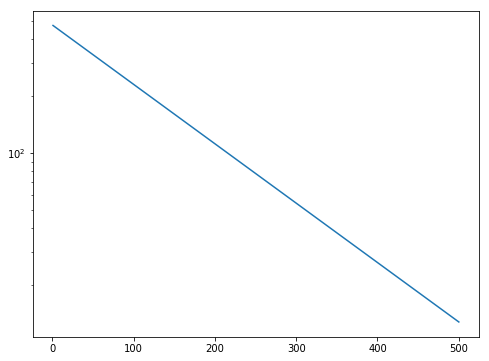

In [8]:
A = np.array([[2, 5, 11, 17, 23], [3, 7, 13, 19, 29]])
b = np.array([228, 227])
I = 500
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)
print(X)

### Exercise 3

Repeat the experiment with $I = 100$ for a random system defined by `A = randn(500,1000)`
and `b = A @ randn(1000)`. 
Compare the iterative solution with the true minimum-norm solution 
$ \hat{\underline{x}} = A^H {(A A^H)}^{-1} \underline{b} $.

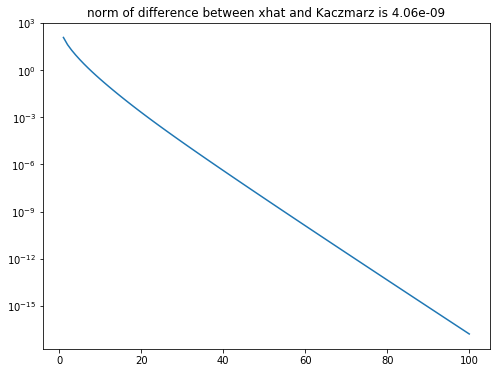

In [11]:

A = randn(500, 1000)
b = A @ randn(1000)
I = 100
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

x_hat = np.dot(np.dot(A.T,inv(np.dot(A,A.T))),b)
x_hat_err = np.square(x_hat-X[:,I-1])
plt.title(f'norm of difference between xhat and Kaczmarz is {np.linalg.norm(x_hat - X[:, -1]):.2e}');



### Exercise 4

Consider the linear program
$$
\min ~ \underline{c}^T \underline{x}
\quad \textrm{subject to} \quad
A \underline{x} \ge \underline{b}, \quad \underline{x} \ge 0
$$
with
$$
\underline{c} = 
\begin{bmatrix}
    3 \\ -1 \\ 2
\end{bmatrix}, \quad
A = 
\begin{bmatrix}
    2 & -1 & 1 \\ 1 & 0 & 2 \\ -7 & 4 & -6
\end{bmatrix}, \quad
\underline{b} = 
\begin{bmatrix}
    -1 \\ 2 \\ 1
\end{bmatrix}, \quad
$$
Let $p^*$ denote the optimum value of this program.
Then, $p^* \le 0$ is satisfied if and only if there is a non-negative $\underline{x} = (x_1, x_2, x_3)^T$ satisfying
$$
\begin{align}
2x_1 - x_2 + x_3 &\ge -1 \\
x_1 + 2x_3 &\ge 2 \\
-7x_1 + 4x_2 - 6x_3 &\ge 1 \\
-3x_1 + x_2 - 2x_3 &\ge 0
\end{align}
$$
where the last inequality restricts the value of the program to be at most $0$.
One can find the optimum value `p` and an optimizer `x` with the command 
```
res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method=’interior-point’)
x, p = res.x, res.fun
```

Starting from $\underline{x}_0 = 0$, write a program that uses alternating projections onto half spaces (see (6)) to find a non-negative vector satisfying the above inequalities. 

Warning: don’t forget to also project onto the half spaces defined by the non-negativity constraints $ x_1 \ge 0, x_2 \ge 0, x_3 \ge 0 $. 

Use the result to find a vector that satisfies all the inequalities. 
How many iterations are required so that the
absolute error is at most 0.0001 in each coordinate?

In [12]:
def proj_HS(v, w, c):
    """
    Projection on half space defined by {v| <v,w> = c}
    Arguments:
        v {numpy.ndarray} -- vector to be projected
        w {numpy.ndarray} -- norm vector of hyperplane  ?
        c {float} -- intercept
    Returns:
        p {numpy.ndarray} -- orthogonal projection of x on half-space <v|w> >= c
    """
    if(np.sum(np.multiply(v,w))<c):
        p = v - (np.sum(np.multiply(v,w)) - c)/np.sum(np.square(w))*w
    else:
        p = v
    return p
    
def proj_NB(v, a, v0):
    """
    Projection on norm ball defined by {v| <v-v0|v-v0> <= a^2}
    Arguments:
        v {numpy.ndarray} -- vector to be projected
        a {float} -- radius of the norm ball
        v0 {numpy.ndarray} -- center of the norm ball
    Returns:
        p {numpy.ndarray} -- orthogonal projection of x on norm ball <v-v0|v-v0> <= a^2
    """
    
    if(np.sum(np.square(v-v0))<= a*a):
        p = v
    else:
        p = v0 + (v-v0)/np.sqrt(np.sum(np.square(v-v0)))*a
        
    return p

In [23]:
def lp_altproj(A, b, I,vstar):
    """
    Find a feasible solution for A v >= b using alternating projection
    with every entry of v0 obeying Uniform[0,1]
    Arguments:
        A {numpy.ndarray} -- matrix defines the LHS of linear equation
        b {numpy.ndarray} -- vector defines the RHS of linear equation
        I {int} -- number of full passes through the alternating projection
    Returns:
        v {numpy.ndarray} -- the output after I full passes
        err {numpy.ndarray} -- the error after each full pass
    """
    m, n = A.shape
    # Apply I sweeps of alternating projection
    v, err = np.zeros(n), np.zeros(I)
    for t in tqdm(range(I * m), total=I*m, leave=False):
        ai = A[t%m]
        bi = b[t%m]
        v = proj_HS(v, ai, bi)
        #if (t + 1) % m == 0:
            #err[t // m] = np.sum(np.square(v-vstar))
    return v, err

     con: array([], dtype=float64)
     fun: 1.8272050539280826e-12
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([8.82960371e-13, 3.84137167e-13, 1.00000000e+00])
  status: 0
 success: True
       x: array([1.50428214e-12, 2.00000000e+00, 1.00000000e+00])


False True


array([1.00000000e-06, 2.00000177e+00, 9.99999093e-01])

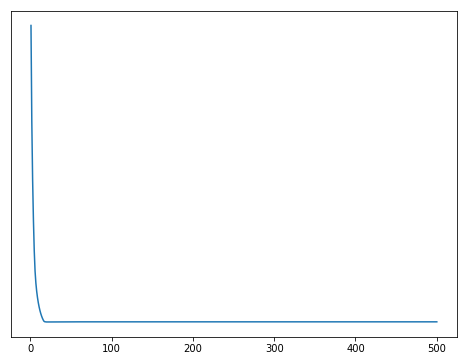

In [15]:
c = np.array([3, -1, 2])
A = np.array([[2, -1, 1], [1, 0, 2], [-7, 4, -6]])
b = np.array([-1, 2, 1])

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method='interior-point')
print(res)

I = 500
# Do not forget constraint xi >= 0
A1 = np.array([[2, -1, 1], [1, 0, 2], [-7, 4, -6],[-3,1,-2],[1,0,0],[0,1,0],[0,0,1]])
b1 = np.array([-1, 2, 1,0,0,0,0])

vstar=np.dot(np.dot(A1.T,inv(np.dot(A1,A1.T))),b1)

x, err = lp_altproj(A1, b1 + 1e-6, I,vstar)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

print(np.all(A @ x - b > 0), np.all(x > 0))
x

### Exercise 5

"
Consider the “random” convex optimization problem defined by
```
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])
```
Modify $A$ and $b$ (by adding one row and one element) so that your function can be used to prove that the value of the convex optimization problem, in (3), is at most −1000. Try using `I = 1000` passes
through all 501 inequality constraints.
This type of iteration typically terminates with an “almost feasible” $\underline{x}$. 
To find a strictly feasible point, try running the same algorithm with the argument $ \underline{b} + \epsilon $ for some small $ \epsilon > 0 $  (e.g., try $ \epsilon = {10}^{-6} $).
Then, the resulting $ \underline{x} $ can satisfy `np.all(A @ x - b > 0)`

(1501, 1000)
(1502, 1000)


True True [-1000.000001]
-1198.5327823523905


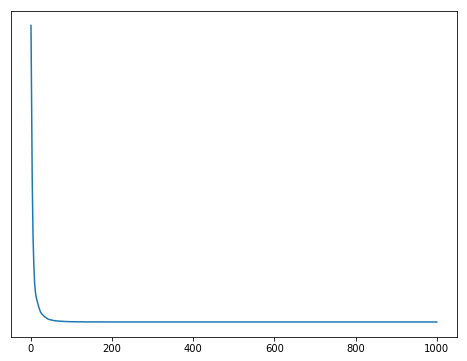

In [16]:
np.random.seed(0)
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])
I, ep = 1000, 1e-6
# Do not forget constraint xi >= 0, and c^T x <= -1000
A1 = np.vstack([A,np.eye(1000)])
print(A1.shape)
b1 = np.concatenate((b,np.zeros(1000)))
A1 = np.vstack([A1,-c])
print(A1.shape)
b1 = np.append(b1,1000)
vstar=np.dot(np.dot(A1.T,inv(np.dot(A1,A1.T))),b1)
x, err = lp_altproj(A1, b1 + ep, I,vstar)
print(np.all(A @ x - b > 0), np.all(x > 0), c.reshape(1, -1) @ x)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * 1000, method='interior-point')
print(res.fun)

### Exercise 6

In [17]:
# read mnist csv file to a dataframe
df = pd.read_csv('mnist_train.csv')
# append feature column by merging all pixel columns
df['feature'] = df.apply(lambda row: row.values[1:], axis=1)
# only keep feature and label column
df = df[['feature', 'label']]

Repeat the MNIST training exercise from the Least-Squares Handout using the training method described above. 
First, extract the indices of all the 0’s and randomly separate the samples into equal-sized training and testing groups. 
Second, do the same for the 1’s. Now, extend each vector to length 785 by appending a −1. This will allow the system to learn a general hyperplane separation.

Extract the all samples labeled with digit $n$ and randomly separate the samples into equal-sized training and testing groups.

In [18]:
def extract_and_split(df, d, test_size=0.5):
    """
    Extract the samples with given lables and randomly separate the samples into equal-sized training and testing groups, extend each vector to length 785 by appending a −1
    Arguments:
        df {dataframe} -- the dataframe of MNIST dataset
        d {int} -- digit needs to be extracted, can be 0, 1, ..., 9
        test_size {float} -- the fraction of testing set, default value is 0.5
    Returns:
        X_tr {numpy.ndarray} -- training set features, a matrix with 785 columns
                                each row corresponds the feature of a sample
        y_tr {numpy.ndarray} -- training set labels, 1d-array
                                each element corresponds the label of a sample
        X_te {numpy.ndarray} -- testing set features, a matrix with 785 columns 
                                each row corresponds the feature of a sample
        y_te {numpy.ndarray} -- testing set labels, 1d-array
                                each element corresponds the label of a sample
    """
    X=[]
    Y=[] 
    for i, row in df.iloc[:].iterrows():
        x, y = row['feature'], row['label']
        if y == d:
            x=np.append(x,[-1])
            X.append(x)
            Y.append(y)
    X=np.asarray(X)
    Y=np.asarray(Y)
    mid=int(round(test_size*Y.size))
    X_tr=X[:mid]
    X_te=X[mid+1:]
    y_tr=Y[:mid]
    y_te=Y[mid+1:]
    return X_tr, X_te, y_tr, y_te    

In [19]:
def remove_outlier(x, thresh=3.5):
    """
    Returns points that are not outliers to make histogram prettier
    reference: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting/11886564
    Arguments:
        x {numpy.ndarray} -- 1d-array, points to be filtered
        thresh {float} -- the modified z-score to use as a threshold. Observations with
                          a modified z-score (based on the median absolute deviation) greater
                          than this value will be classified as outliers.
    Returns:
        x_filtered {numpy.ndarray} -- 1d-array, filtered points after dropping outlier
    """
    if len(x.shape) == 1: x = x[:,None]
    median = np.median(x, axis=0)
    diff = np.sqrt(((x - median)**2).sum(axis=-1))
    modified_z_score = 0.6745 * diff / np.median(diff)
    x_filtered = x[modified_z_score <= thresh]
    return x_filtered

Next, use alternating projections to design a linear classifier to separate for 0’s and 1’s. For the resulting linear function, report the classification error rate and confusion matrices for the both the training and test sets. Also, for the test set, compute the histogram of the function output separately for each class and then plot the two histograms together. 
This shows easy or hard it is to separate the two classes.

Depending on your randomized separation into training and test sets, the training data may or may not be linearly separable. 
Comment on what happens to the test set performance when the error rate does converge to zero for the training set.

Pairwise experiment for applying least-square to classify digit $a$ and digit $b$. 

Follow the given steps in the template and implement the function for pairwise experiment

In [20]:
def mnist_pairwise_altproj(df, a, b, solver, test_size=0.5, verbose=False):
    """
    Pairwise experiment for applying alternating projection to classify digit a and digit b
    Arguments:
        df {dataframe} -- the dataframe of MNIST dataset
        a, b {int} -- digits to be classified
        test_size {float} -- the fraction of testing set, default value is 0.5
        solver {function} -- function to compute linear classifier
        verbose {bool} -- whether to print and plot results
    Returns:
        z_hat {numpy.ndarray} -- coefficients for linear classifier
        res {numpy.ndarray} -- numpy.array([traing error, testing error])
    """
    
    # Find all samples labeled with digit a and split into train/test sets
    Xa_tr, Xa_te, ya_tr, ya_te = extract_and_split(df, a, test_size)
    # Find all samples labeled with digit b and split into train/test sets
    Xb_tr, Xb_te, yb_tr, yb_te = extract_and_split(df, b, test_size)

    # Construct the full training set
    X_tr = np.concatenate((Xa_tr,Xb_tr))
    y_tr = np.concatenate((ya_tr,yb_tr))
    
    # Construct the full testing set
    X_te = np.concatenate((Xa_te,Xb_te))
    y_te = np.concatenate((ya_te,yb_te))
    
    # Run solver on training set to get linear classifier
    A_tilde = np.concatenate((-Xa_tr,Xb_tr))
    b1 = np.ones((np.size(X_tr,0)))
    vstar=np.dot(np.dot(A_tilde.T,inv(np.dot(A_tilde,A_tilde.T))),b1)
    z_hat, err = solver(A_tilde,b1,100,vstar)
  
    # Compute estimation and misclassification on training set
    y_hat_tr = np.dot(X_tr,z_hat)
    err_tr = 0
    
    for i in range(y_hat_tr.size):
        if (( y_hat_tr[i] < 0) and (y_tr[i] == b))or((y_hat_tr[i] >= 0)and(y_tr[i] == a)):
            err_tr=err_tr+1
        
    err_tr = err_tr/y_hat_tr.size
   
    # Compute estimation and misclassification on testing set
    y_hat_te = np.dot(X_te,z_hat)
    err_te = 0
    
    for i in range(y_hat_te.size):
        if (( y_hat_te[i] < 0) and (y_te[i] == b))or((y_hat_te[i] >= 0)and(y_te[i] == a)):
            err_te=err_te+1
      
    err_te = err_te/y_hat_te.size
 
    if verbose:
       
        print('Pairwise experiment, mapping {0} to -1, mapping {1} to 1'.format(a, b))
        print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
        
        # Compute confusion matrix for training set
        cm_tr = np.zeros((2,2))
       
        for i in range(y_hat_tr.size):
            if (( y_hat_tr[i] < 0) and (y_tr[i] == b)):
             
                cm_tr[1][0]=cm_tr[1][0]+1            
            elif ((y_hat_tr[i] >= 0)and(y_tr[i] == a)):
                cm_tr[0][1]=cm_tr[0][1]+1
                          
            elif y_tr[i] ==b:
                cm_tr[1][1]= cm_tr[1][1]+1
            else:
                cm_tr[0][0]= cm_tr[0][0]+1
        print('Training set confusion matrix:\n {0}'.format(cm_tr.astype(int)))
        
        # Compute confusion matrix for testing set
        cm_te = np.zeros((2,2))
       
        for i in range(y_hat_te.size):
            if (( y_hat_te[i] < 0) and (y_te[i] == b)):
             
                cm_te[1][0]=cm_te[1][0]+1            
            elif ((y_hat_te[i] >= 0)and(y_te[i] == a)):
                cm_te[0][1]=cm_te[0][1]+1
                           
            elif y_te[i] ==b:
                cm_te[1][1]= cm_te[1][1]+1
            else:
                cm_te[0][0]= cm_te[0][0]+1
        print('Testing set confusion matrix:\n {0}'.format(cm_te.astype(int)))

         #Compute the histogram of the function output separately for each class 
         #Then plot the two histograms together
        ya_te_hat = y_hat_te[:ya_te.size-1]
        yb_te_hat =  y_hat_te[ya_te.size:]
        output = [remove_outlier(ya_te_hat), remove_outlier(yb_te_hat)]
        plt.figure(figsize=(8, 4))
        plt.hist(output, bins=50)
   
    res = np.array([err_tr, err_te])
    return z_hat, res

Pairwise experiment, mapping 0 to -1, mapping 1 to 1
training error = 0.00%, testing error = 0.09%
Training set confusion matrix:
 [[2066    0]
 [   0 2342]]
Testing set confusion matrix:
 [[2063    2]
 [   2 2339]]


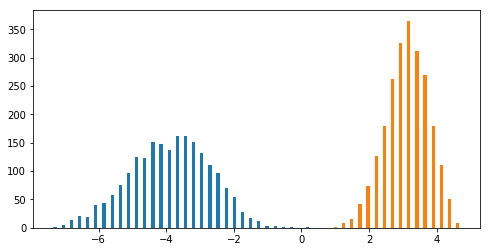

In [21]:
solver = lambda A, b,I,vstar: lp_altproj(A, b + 1e-6, I, vstar)
z_hat, res= mnist_pairwise_altproj(df, 0, 1, solver, 0.5,verbose=True)



### Exercise 7

Describe how this approach should be extended to multi-class linear classification
(parameterized by $ Z \in \mathbb{R}^{n \times d} $) where the classifier maps a vector $\underline{v}$ to class $j$ if the $j$-th element
of $ Z^T \underline{v} $ is the largest element in the vector. 
Use the implied alternating-projection solution to design a multi-class classifier for MNIST.

In [22]:
def mnist_multiclass_altproj(df, solver, test_size=0.5):
    """
    Experiment for applying least-square to classify all digits using one-hot encoding
    Arguments:
        df {dataframe} -- the dataframe of MNIST dataset
        solver {function} -- function to compute linear classifier
        test_size {float} -- the fraction of testing set, default value is 0.5
    Returns:
        Z {numpy.ndarray} -- coefficients for linear classifier
        res {numpy.ndarray} -- numpy.array([traing error, testing error])
    """
    # Split into training/testing set
    X=[]
    Y=[] 
    for i, row in df.iloc[:].iterrows():
        x, y = row['feature'], row['label']
        x=np.append(x,[-1])
        X.append(x)
        Y.append(y)
    X=np.asarray(X)
    Y=np.asarray(Y)
    mid=int(round(test_size*Y.size))
    
    # Construct the training set
    X_tr=X[:mid]
    y_tr=Y[:mid]
   
    # Construct the testing set
    X_te=X[mid:]
    y_te=Y[mid:]
    
    # Construct A_tilde b_tilde
    A_tilde = np.zeros((y_tr.size*9,7850))
    
    for i in range(0,y_tr.size):
        len=785
        ba=np.zeros((10,len*10))
        bb=np.zeros((10,len*10))
        for k in range(0,10):
            for j in range(0,10): 
                if(j==y_tr[i]):
                    ba[k][j*len:(j+1)*len]=X_tr[i,:]          
                if k==j:
                    bb[k][j*len:(j+1)*len]=X_tr[i,:]
        b=ba-bb
        bbb=np.delete(b,y_tr[i],axis=0)
        A_tilde[i*9:(i+1)*9,:] = bbb
   
    b_tilde = np.zeros((y_tr.size*9))
    #vstar=np.dot(np.dot(A_tilde.T,inv(np.dot(A_tilde,A_tilde.T))),bb)
    vstar = 0
    # Run solver on training set to get linear classifier
    Z, err = solver(A_tilde,b_tilde.T,100,vstar)
    # Reshape Z as a 785 x 10 matrix
    Z = Z.reshape(10,785).T
   
    # Compute estimation and misclassification on training set
    y_hat_tr = np.zeros((y_tr.size))
    err_tr = 0
    cm_tr=np.zeros((10,10))
    for i in range(0,y_tr.size):
        yi=np.argmax(np.dot(X_tr[i].T,Z))    
        if yi != y_tr[i]:
            err_tr = err_tr + 1 
        cm_tr[y_tr[i]][yi]=cm_tr[y_tr[i]][yi]+1
    err_tr=err_tr/y_tr.size
    # Compute estimation and misclassification on training set
    y_hat_te = np.zeros((y_te.size))
    err_te = 0
    cm_te=np.zeros((10,10))
    for i in range(0,y_te.size):
        yi=np.argmax(np.dot(X_te[i].T,Z))    
        if yi != y_te[i]:
            err_te = err_te + 1 
            cm_te[y_te[i]][yi]=cm_te[y_te[i]][yi]+1
        else:
            cm_te[y_te[i]][y_te[i]]=cm_te[y_te[i]][y_te[i]]+1
    err_te=err_te/y_te.size
    print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
    # Compute confusion matrix for training set
    
    print('Training set confusion matrix:\n {0}'.format(cm_tr.astype(int)))
    # Compute confusion matrix for testing set
   
    print('Testing set confusion matrix:\n {0}'.format(cm_te.astype(int)))
    
    res = np.array([err_tr, err_te])
   
    return Z,res

In [24]:
solver = lambda A, b,I,vstar: lp_altproj(A, b + 1e-6, I, vstar)
Z,res = mnist_multiclass_altproj(df, solver)


MemoryError: 

### Exercise 8

Let $ V = \mathbb{R}^2 $ and consider the orthogonal projection of $ \underline{u} = (1, -2) $ onto the intersection of
$$
\begin{align}
    C_1 &= \left\{ \underline{v} \in V \,\mid\, v_2 \ge 0 \right\} \\
    C_2 &= \left\{ \underline{v} \in V \,\mid\, v_1^2 + \left(v_2 - \frac{\sqrt{3}}{2}\right)^2 \le 1 \right\}
\end{align}
$$
Draw a picture illustrating the algernating projections (without Dykstra's modification) defined by: $ P_{C_2}(P_{C_1}(\underline{u})) $ and $ P_{C_1}(P_{C_2}(\underline{u})) $.
Does either give the desired result $ P_{C_1 \cap C_2}(\underline{u}) $?
Now, try Dykstra's algorithm using both orders and 4 iterations.
Are these approaching $ P_{C_1 \cap C_2}(\underline{u}) $?

In [ ]:
P_C1 = 
P_C2 = 
P = [P_C1, P_C2]

# Alternating Projection P_{C_2}(P_{C_1}(u))
us1 = [np.array([1.0, -2.0]), np.array([1.0, -2.0])]
while True:
    u = 
    if np.linalg.norm(us1[-2] - u) >= 1e-4:
        us1.append(u)
    else:
        break
        
# Alternating Projection P_{C_1}(P_{C_2}(u))
us2 = [np.array([1.0, -2.0]), np.array([1.0, -2.0])]
while True:
    u = 
    if np.linalg.norm(us2[-2] - u) >= 1e-4:
        us2.append(u)
    else:
        break

# Dykstra's Algorithm
vs, w = [np.array([1.0, -2.0]), np.array([1.0, -2.0])], np.zeros((2, 2))
while True:
    v = 
    w = 
    if np.linalg.norm(vs[-2] - v) >= 1e-4:
        vs.append(v)
    else:
        break

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
# Plot half space part
x, y = np.linspace(-0.5, 0.5, 101), np.zeros(101)
plt.plot(x, y, color='yellow', linewidth=2)
# Plot unit ball part
x = np.linspace(-1, 1, 101)
y = np.sqrt(3)/2 + np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(-1, -0.5, 101)
y = np.sqrt(3)/2 - np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(0.5, 1, 101)
y = np.linspace(0.5, 1, 101)
plt.plot(x, np.sqrt(3)/2 - np.sqrt(1 - y**2), color='yellow', linewidth=2)
plt.scatter(*np.array(us1).T, c='red', marker='+', alpha=0.5, label=r'$P_{C_2}(P_{C_1}(u))$')
plt.scatter(*np.array(us2).T, c='blue', marker='x', alpha=0.5, label=r'$P_{C_1}(P_{C_2}(u))$')
plt.scatter(*np.array(vs).T, c='green', marker='1', alpha=0.5, label='Dykstra')
plt.axis('equal')
plt.legend()
plt.title('Trajectories of different methods')

plt.subplot(1, 2, 2)
# Plot half space part
x, y = np.linspace(-0.5, 0.5, 101), np.zeros(101)
plt.plot(x, y, color='yellow', linewidth=2)
# Plot unit ball part
x = np.linspace(-1, 1, 101)
y = np.sqrt(3)/2 + np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(-1, -0.5, 101)
y = np.sqrt(3)/2 - np.sqrt(1 - x**2)
plt.plot(x, y, color='yellow', linewidth=2)
x = np.linspace(0.5, 1, 101)
y = np.linspace(0.5, 1, 101)
plt.plot(x, np.sqrt(3)/2 - np.sqrt(1 - y**2), color='yellow', linewidth=2)
size = 300 * np.linspace(0.2, 1, len(us1))
plt.scatter(*np.array(us1).T, c='red', marker='+', s=size, alpha=0.5, label=r'$P_{C_2}(P_{C_1}(u))$')
plt.scatter(us1[-1][0], us1[-1][1], s=300, facecolors='none', edgecolors='red', linewidth=2)
size = 300 * np.linspace(0.2, 1, len(us2))
plt.scatter(*np.array(us2).T, c='blue', marker='x', s=size, alpha=0.5, label=r'$P_{C_1}(P_{C_2}(u))$')
plt.scatter(us2[-1][0], us2[-1][1], s=300, facecolors='none', edgecolors='blue', linewidth=2)
size = 300 * np.linspace(0.2, 1, len(vs))
plt.scatter(*np.array(vs).T, c='green', marker='1', s=size, alpha=0.5, label='Dykstra')
plt.scatter(vs[-1][0], vs[-1][1], s=300, facecolors='none', edgecolors='green', linewidth=2)
plt.xlim([0.25, 1.05])
plt.ylim([-0.35, 0.45])
plt.legend()
plt.title('Zoom-in trajectories')